## Import libraries

In [1]:
import os
import sys
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm_notebook
sys.path.append('./Model')
from My_ViT import VisionTransformer, img_to_patch

In [2]:
model = torch.load('./Training/training_occlusions.pth')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
print("Device:", device)
random.seed(42)
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device: mps


In [3]:
image_size = 28
embed_dim=255
hidden_dim=embed_dim*3
num_heads=3
num_layers=6
patch_size=7
num_patches=16
num_channels=1
num_classes=10
dropout=0.2

## Downloading FashionMNIST from torchvision

In [4]:
# set the preprocess operations to be performed on train/val/test samples
MNIST_preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.5,), (0.5,))
                                                   ])

# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/training', train=True, download=True, transform=MNIST_preprocess)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# download MNIST test set
test_set = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/testing', train=False, download=True, transform=MNIST_preprocess)

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

In [5]:
#ORIGINAL VISUALIZATION

test_sample_index_1 = (test_set.targets == 1).nonzero(as_tuple=True)[0][7].item()
test_sample_index_5 = (test_set.targets == 5).nonzero(as_tuple=True)[0][7].item()
test_sample_index_7 = (test_set.targets == 7).nonzero(as_tuple=True)[0][7].item()
test_sample_index_8 = (test_set.targets == 8).nonzero(as_tuple=True)[0][7].item()

img_1 = test_set.data[test_sample_index_1]
img_5 = test_set.data[test_sample_index_5]
img_7 = test_set.data[test_sample_index_7]
img_8 = test_set.data[test_sample_index_8]

In [6]:
def get_attention_maps_layer(images, mode, layer):
    fig, axes = plt.subplots(4, 1, figsize=(5, 20))
    fig.suptitle(f'layer { layer + 1}', fontsize=35)

    for i, img_tensor in enumerate(images):
        img_tensor = img_tensor.to(device)
        patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
        patches = model.input_layer(patches.float())
        transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
        transformer_input_expanded = model.transformer[layer].linear[0](transformer_input).squeeze(0)
        qkv = transformer_input_expanded.reshape(num_patches+1, 3, num_heads, -1)
        q = qkv[:, 0].permute(1, 0, 2)
        k = qkv[:, 1].permute(1, 0, 2)
        kT = k.permute(0, 2, 1)
        attention_matrix = q @ kT

        if mode == "mean":
            attention_matrix = attention_matrix.mean(dim=0)
        elif mode == "min":
            attention_matrix, _ = torch.min(attention_matrix, dim=0)
        elif mode == "max":
            attention_matrix, _ = torch.max(attention_matrix, dim=0)

        residual_att = torch.eye(attention_matrix.size(1)).to(device)
        aug_att_mat = attention_matrix + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
        attn_heatmap = aug_att_mat[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
        attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(image_size, image_size, 1)
        attn_heatmap_resized = attn_heatmap_resized - attn_heatmap_resized.min()
        attn_heatmap_resized = attn_heatmap_resized / attn_heatmap_resized.max()


        heatmap = axes[i].imshow(attn_heatmap_resized.detach().cpu().numpy(), cmap='viridis')
        axes[i].axis('off')
        cbar = fig.colorbar(heatmap, ax=axes[i], fraction=0.046, pad=0.04, format='%.2f')
        cbar.ax.tick_params(labelsize=15)  # Modifica la dimensione dei valori sulla colorbar

    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Aggiusta il layout per il titolo
    plt.savefig(f'./IMAGES/LAYERWISE/mean_attention_maps_layer_{layer + 1}.png')
    return fig


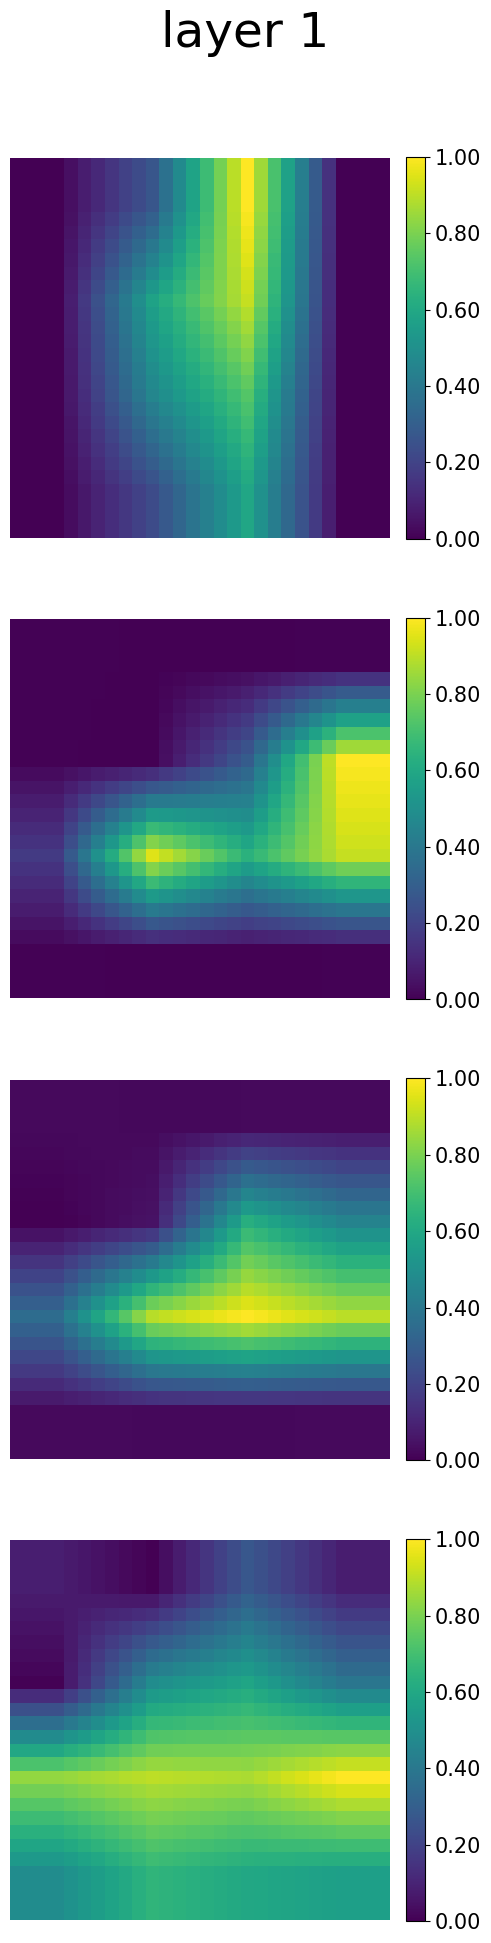

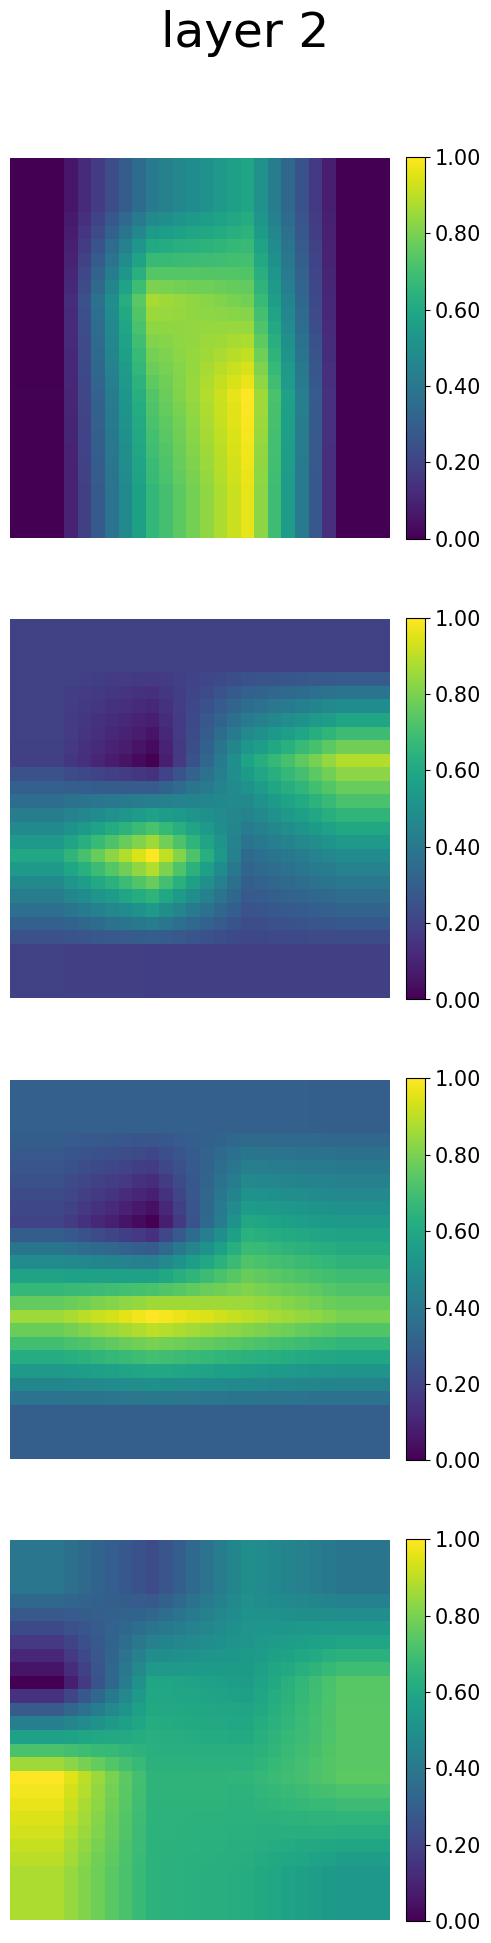

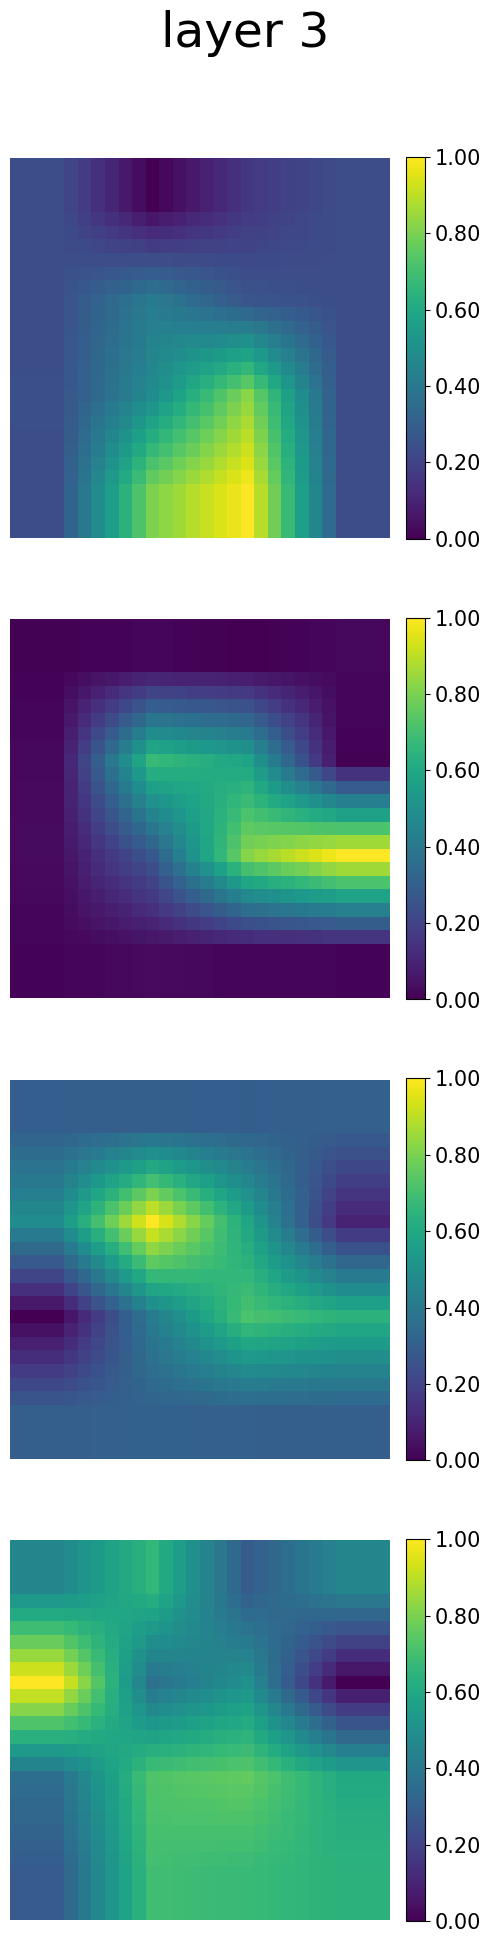

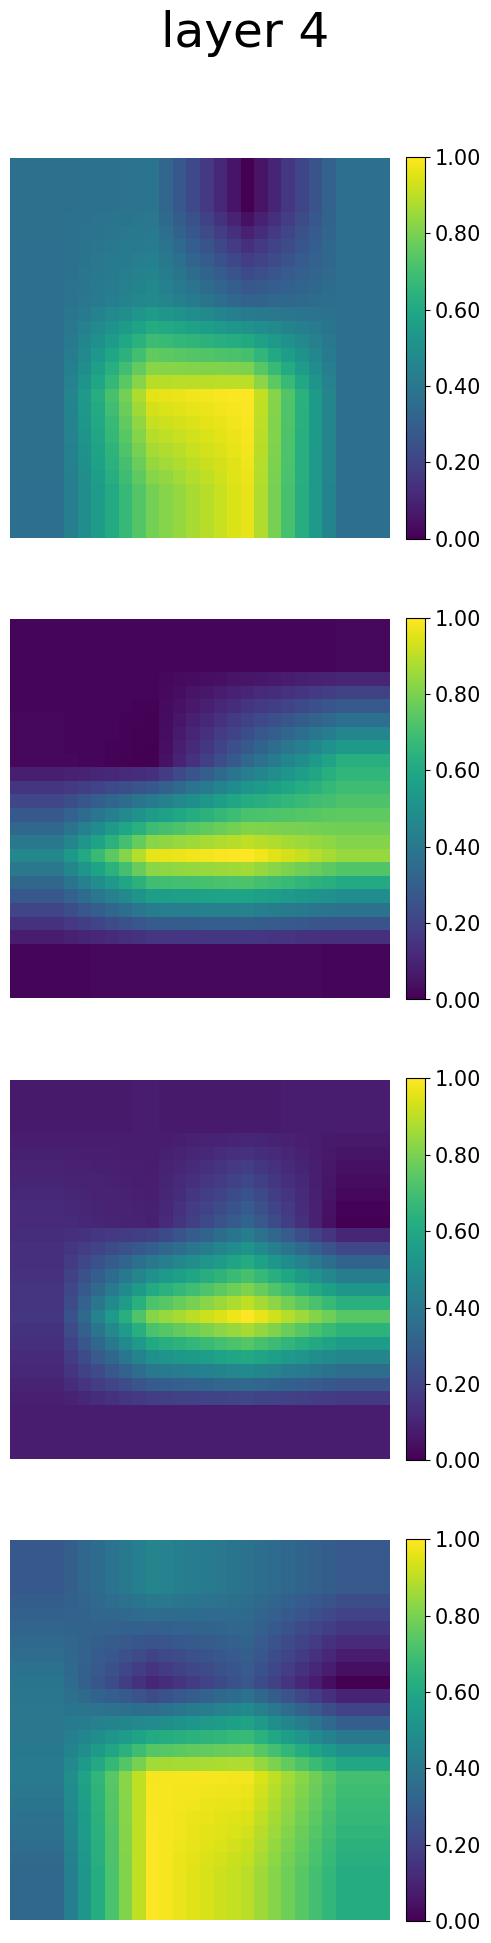

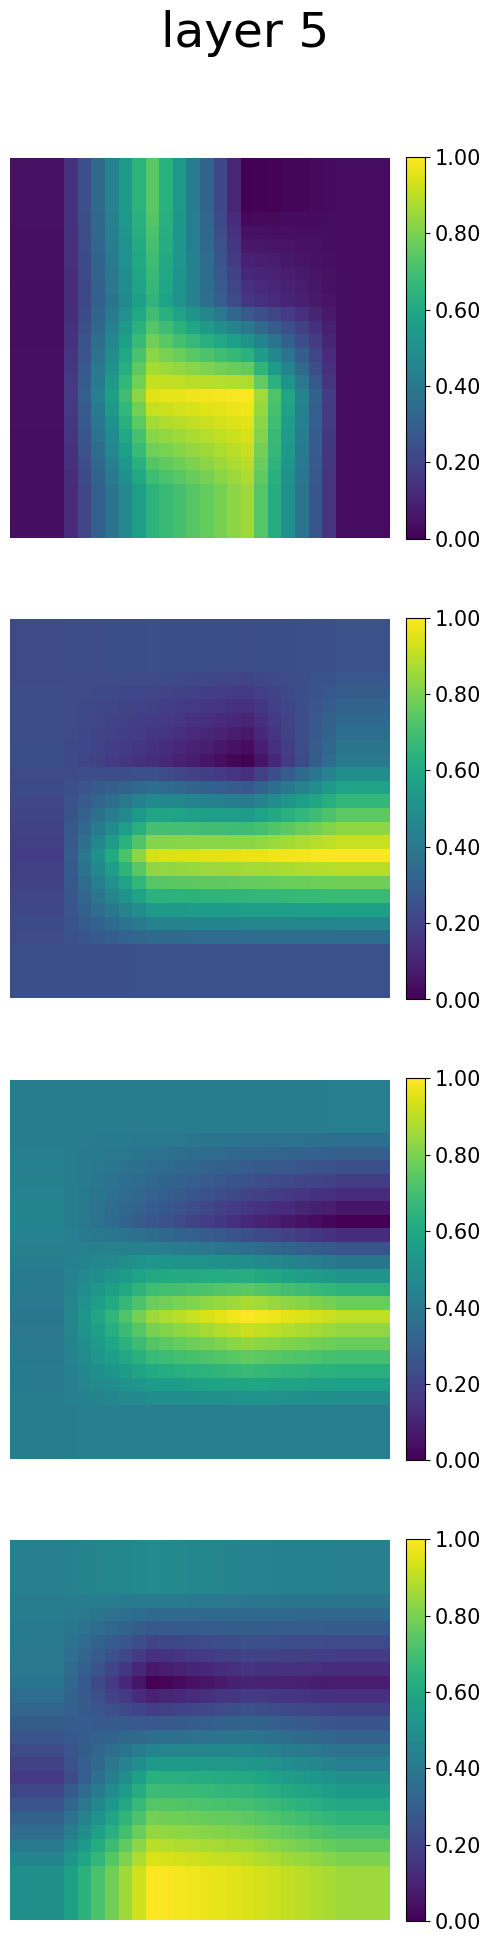

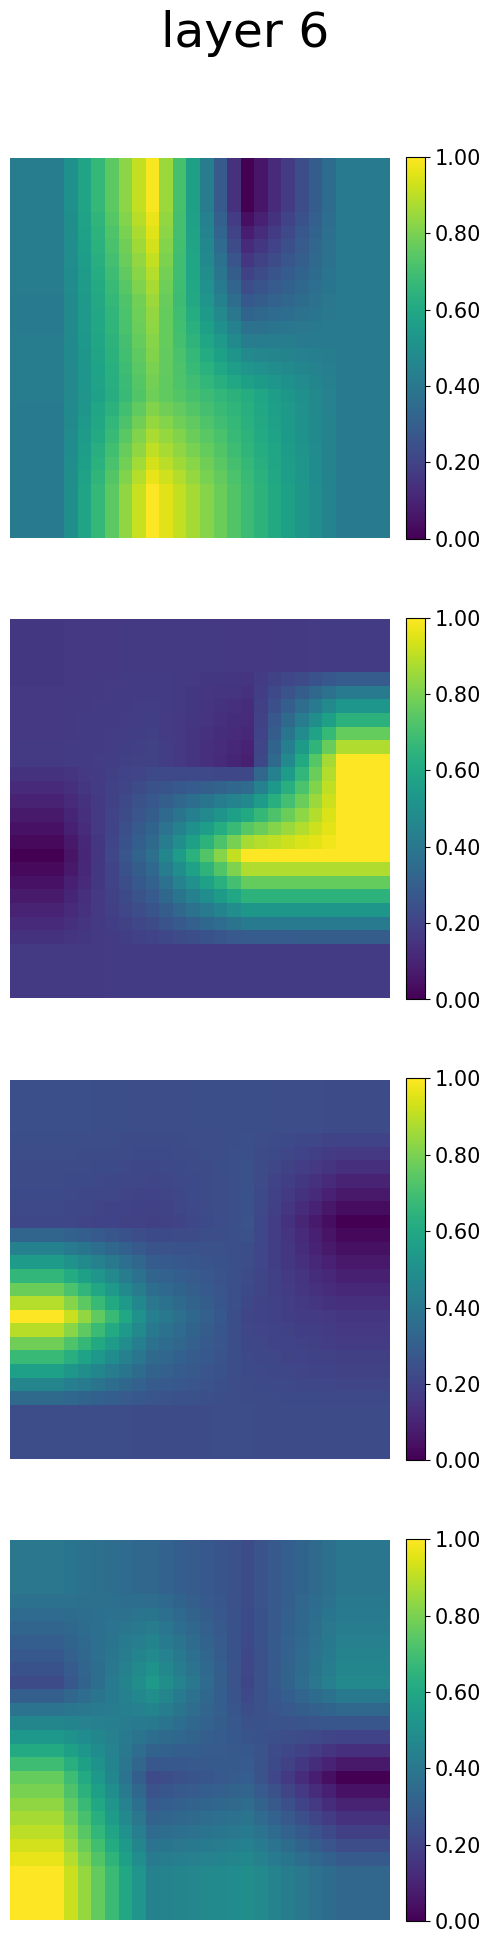

In [7]:
imgs = [img_1, img_5, img_7, img_8]  
layer_1 = get_attention_maps_layer(imgs, mode='mean', layer=0)
layer_2 = get_attention_maps_layer(imgs, mode='mean', layer=1)
layer_3 = get_attention_maps_layer(imgs, mode='mean', layer=2)
layer_4 = get_attention_maps_layer(imgs, mode='mean', layer=3)
layer_5 = get_attention_maps_layer(imgs, mode='mean', layer=4)
layer_6 = get_attention_maps_layer(imgs, mode='mean', layer=5)